## Notes

This snippet is taking from deep-forecasting by Daniel Herkert. Btc price is trying to be predicted. It uses some features like open close ratio and so on. But in our context we are using it as follows

last N hours of data is taken in a batch, say from Hour0 to Hour99, it has Production0 to Production99 values and Feature1_0 to Feature8_99 values, 9 * 100 feature goes into the model, and model tries to predict Production100 value.

We need to add
- Utilizing Feature1_100 to Feature8_100 for prediction of Prod100 (almost done)
- Predicting Prod100 to Prod124 in a single shot (almost done)
- scaling seperately for each rt_plant_id
- scaling for capacity (utilization)

### Resources 
- https://stackoverflow.com/questions/56858924/multivariate-input-lstm-in-pytorch
- https://github.com/danielhkt/deep-forecasting
    - main code is taken from here
- https://www.crosstab.io/articles/time-series-pytorch-lstm
- https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2
    - Shifting of y
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/
    - seq2seq introduction
    - lstm autoregressive tasklarda çok iyi çalışmayabilir diyor, seq2seq'te encoder cnn decoder lstm kullanan bi approachtan bahsediyor
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
    - multistep lstm
    - multivariate lstm
    - multivariate & multistep lstm




## Read Data

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_parquet("data/wind/2019-01-24_outlier_removed.parquet")    
# df = pd.read_parquet("/content/drive/MyDrive/thesis/data/2019-01-24_outlier_removed.parquet")
df = df[~df["rt_plant_id"].isin([2397, 2420, 2538])]
print(df.shape)

(2586416, 16)


In [3]:
selected_plants = df.groupby("rt_plant_id")[["production"]].sum().sort_values("production", ascending=False).index[:1].to_list()
print(selected_plants)
df = df[df["rt_plant_id"].isin(selected_plants)].reset_index(drop=True)
print(df.shape)

[969]
(26392, 16)


In [4]:
weather_cols = [col for col in df.columns if col.startswith(("UGRD", "VGRD"))]

df.forecast_dt = df.forecast_dt.dt.tz_localize(None)
df = df.set_index("forecast_dt")[["rt_plant_id", "production", *weather_cols]]

df = df[df.index > "2021-01-01"]

df = df.groupby("rt_plant_id").resample("1H").interpolate()
df = df.drop(columns=["rt_plant_id"]).reset_index().set_index("forecast_dt").sort_index()

In [5]:
df.head()

,rt_plant_id,production,UGRD_80.m.above.ground.SW,UGRD_80.m.above.ground.NW,UGRD_80.m.above.ground.NE,UGRD_80.m.above.ground.SE,VGRD_80.m.above.ground.SW,VGRD_80.m.above.ground.NW,VGRD_80.m.above.ground.NE,VGRD_80.m.above.ground.SE
forecast_dt,,,,,,,,,,
2021-01-01 01:00:00,969,149.0,-0.703479,-0.713479,-0.163479,-0.033479,3.54302,2.04302,3.70302,4.95302
2021-01-01 02:00:00,969,188.0,-1.021530,-0.931533,-0.511533,-0.531533,3.26271,1.76271,3.49271,4.75271
2021-01-01 03:00:00,969,195.0,-1.173110,-1.243110,-0.273107,-0.693107,3.46422,1.78422,3.56422,4.54422
2021-01-01 04:00:00,969,197.0,-1.257270,-1.307270,-0.647266,-0.917266,3.23561,1.70561,3.06561,3.78561
2021-01-01 05:00:00,969,211.0,-0.950615,-0.970615,0.149385,-0.560615,3.36557,1.63557,3.11557,3.93557


In [6]:
PLANTS = sorted(df.rt_plant_id.unique())

def expand_plant_dimension(df):
    n_loc = len(PLANTS)
    n_time = df.index.nunique()
    cols = [col for col in df.columns if col != "rt_plant_id"]
    n_cols = len(cols)

    df_np = np.zeros((n_loc, n_time, n_cols))
    for i, plant_id in enumerate(PLANTS):
        df_np[i, :, :] = df[df.rt_plant_id == plant_id][cols].values
    return df_np

## Train Test Split & Shifting

In [ ]:
# I shifted production values by 48
# and then splited them into train and test, some observations in train (last 48) should be used in test
# or simply we can shift in test and ignore first 48 hours

In [7]:
apply_shift = False
n_steps = 48

if apply_shift:
    df["original_production"] = df["production"]

In [8]:
time_indices = sorted(df.index.unique())
train_ratio = 0.8

train_indices = time_indices[:int(len(time_indices) * train_ratio)]
test_indices = time_indices[int(len(time_indices) * train_ratio):]

if apply_shift:
    df.loc[test_indices, "production"] = np.nan
    df["production"] = df.groupby("rt_plant_id").production.shift(n_steps)

test_df = df.loc[test_indices, :]
train_df = df.loc[train_indices, :]

if apply_shift:
    train_df = train_df.dropna()
    df = pd.concat([train_df, test_df]) 
    intersect = set(train_indices).intersection(df.index)
    df = df.loc[intersect, :]

In [9]:
train_df_np = expand_plant_dimension(train_df)
test_df_np = expand_plant_dimension(test_df)

In [10]:
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

scalers = {}
for i in range(train_df_np.shape[0]):
    scalers[PLANTS[i]] = MinMaxScaler()
    train_df_np[i, :, :] = scalers[PLANTS[i]].fit_transform(train_df_np[i, :, :])

for i in range(train_df_np.shape[0]):
    test_df_np[i, :, :] = scalers[PLANTS[i]].transform(test_df_np[i, :, :])

In [11]:
train_df_np = train_df_np.reshape(-1, 9)
test_df_np = test_df_np.reshape(-1, 9)

In [ ]:
# plant_id = 0
# print(PLANTS[plant_id])
# pd.DataFrame(scalers[plant_id].inverse_transform(test_df_np[plant_id]))

# test_df[test_df["rt_plant_id"] == PLANTS[plant_id]]

In [12]:
model_dir = "data/wind"

## Scaling (Not for now)

In [ ]:
# scaling for each rt plant id seperately
# train_df = train_df.groupby("rt_plant_id").transform(lambda x: (x - x.mean()) / x.std())

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import joblib
from pathlib import Path

scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

train_df = pd.DataFrame(
    scaler.transform(train_df),
    index=train_df.index,
    columns=train_df.columns)

# save trained data scaler
joblib.dump(scaler, Path(model_dir, 'scaler.gz'))

scaler = joblib.load(Path(model_dir, 'scaler.gz'))
test_df = pd.DataFrame(
    scaler.transform(test_df),
    index=test_df.index,
    columns=test_df.columns)

## Data Loader

In [13]:
if len(train_df_np.shape) == 2:
    X_train, y_train = train_df_np[:, 1:], train_df_np[:, 0]
    X_test, y_test = test_df_np[:, 1:], test_df_np[:, 0]
    print(X_train.shape, y_train.shape)

elif len(train_df_np.shape) == 3:
    X_train, y_train = train_df_np[:, :, 1:], train_df_np[:, :, 0]
    X_test, y_test = test_df_np[:, :, 1:], test_df_np[:, :, 0]
    print(X_train.shape, y_train.shape)

(7525, 8) (7525,)


In [87]:
from torch.utils.data import Dataset, DataLoader

sequence_length = 6 * 24
batch_size = 10 * 24
n_epochs = 20
n_epochs_stop = 5

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length
        
    def __len__(self):
        return self.X.shape[0] - self.sequence_length

    def __getitem__(self, index):
        return self.X[index:index+self.sequence_length], self.y[index+self.sequence_length]

train_dataset = TimeSeriesDataset(X_train, y_train, sequence_length=sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TimeSeriesDataset(X_test, y_test, sequence_length=sequence_length)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [88]:
class TSModel(nn.Module):
    def __init__(self, n_features, n_hidden=100, n_layers=4, n_steps=1):
        super(TSModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            batch_first=True,
            num_layers=n_layers,
            dropout=0.2
        )
        self.linear = nn.Linear(n_hidden, n_steps)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        lstm_out = hidden[-1]  # output last hidden state output
        y_pred = self.linear(lstm_out)

        return y_pred


In [89]:
n_features = X_train.shape[-1]
model = TSModel(n_features)
criterion = torch.nn.MSELoss()  # L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [90]:
train_hist = []
test_hist = []

# start training
best_loss = np.inf
n_epochs = 20
epochs_no_improve = 0
for epoch in range(1, n_epochs+1):
    running_loss = 0
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader, 1):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        data = torch.Tensor(np.array(data))
        output = model(data)
        loss = criterion(output.flatten(), target.type_as(output))
        # if type(criterion) == torch.nn.modules.loss.MSELoss:
        #     loss = torch.sqrt(loss)  # RMSE
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    running_loss /= len(train_loader)
    train_hist.append(running_loss)

    # test loss
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = torch.Tensor(np.array(data))
            output = model(data)
            loss = criterion(output.flatten(), target.type_as(output))
            test_loss += loss.item()
        test_loss /= len(test_loader)
        test_hist.append(test_loss)

        # early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            torch.save(model.state_dict(), Path(model_dir, 'model.pt'))
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print("Early stopping.")
            break

    print(f'Epoch {epoch} train loss: {round(running_loss,4)} test loss: {round(test_loss,4)}')

    hist = pd.DataFrame()
    hist['training_loss'] = train_hist
    hist['test_loss'] = test_hist


Epoch 1 train loss: 0.1371 test loss: 0.0915
Epoch 2 train loss: 0.1043 test loss: 0.0944
Epoch 3 train loss: 0.1015 test loss: 0.0916
Epoch 4 train loss: 0.0995 test loss: 0.0905
Epoch 5 train loss: 0.0987 test loss: 0.0909
Epoch 6 train loss: 0.0984 test loss: 0.091
Epoch 7 train loss: 0.0971 test loss: 0.1164
Epoch 8 train loss: 0.0969 test loss: 0.0903
Epoch 9 train loss: 0.0944 test loss: 0.0988
Epoch 10 train loss: 0.0991 test loss: 0.0924
Epoch 11 train loss: 0.0871 test loss: 0.1007
Epoch 12 train loss: 0.0836 test loss: 0.1101
Early stopping.


In [91]:
df = test_df
label_name = 'production'


model = TSModel(n_features)
model.load_state_dict(torch.load(Path(model_dir, 'model.pt')))
model.eval()

test_dataset = TimeSeriesDataset(X_test, y_test, sequence_length=sequence_length)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

predictions = []
labels = []
with torch.no_grad():
    for features, target in test_loader:
        features = torch.Tensor(np.array(features))
        output = model(features)
        predictions.append(output.item())
        labels.append(target.item())


In [92]:
# bring predictions back to original scale
# scaler = joblib.load(Path(model_dir, 'scaler.gz'))
scaler = scalers[PLANTS[0]]
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[0], scaler.scale_[0]

def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)

<AxesSubplot:>

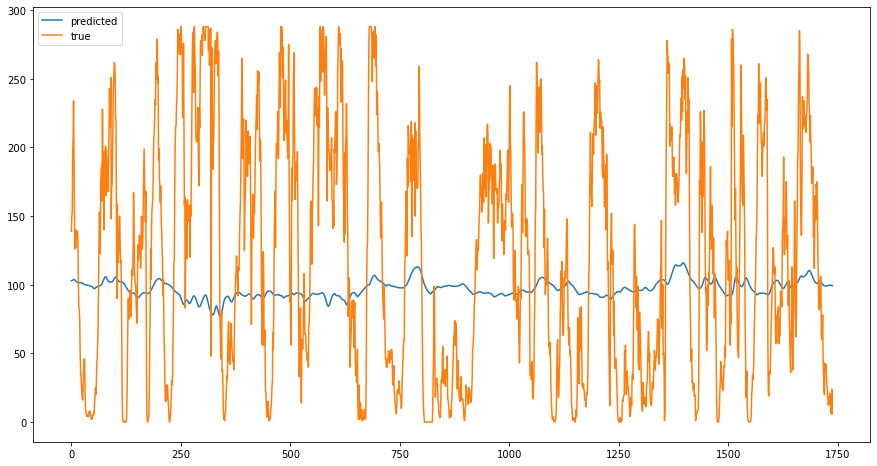

In [93]:
df_pred = pd.DataFrame()
df_pred['predicted'] = predictions_descaled
df_pred['true'] = labels_descaled
# df_pred['residual'] = labels_descaled - predictions_descaled
df_pred.plot(figsize=(15,8))

In [ ]:
n_window = 24
n_loc = df.rt_plant_id.nunique()
n_feat = len(weather_cols)
n_time = df.index.nunique()
num = n_time - n_window + 1

x = np.zeros([n_loc, num, n_feat, n_window])
y = np.zeros([n_loc, num, n_window])

for i, plant_id in enumerate(sorted(df.rt_plant_id.unique())):
    df_ = df[df["rt_plant_id"] == plant_id]
    for j in range(num):
        for k, feat in enumerate(weather_cols):
            x[i, j, k, :] = df_[feat][j: j+n_window].values
            # x[i, k, :] = df_[feat].values
        y[i, j, :] = df_["production"][j: j+n_window].values
        # y[i, :] = df_["production"].values

In [ ]:
x.shape, y.shape

In [ ]:
np.transpose(x, [0, 2, 1])[:, 0, :]

In [ ]:
x[:, :, 0]